In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt

In [3]:
#define the main_path to extract the dataset
main_path = './'

#getting the train dataset from the folder
train_normal = glob(os.path.join(main_path, 'train', 'NORMAL', '*.jpeg'))
train_pneumonia = glob(os.path.join(main_path, 'train', 'PNEUMONIA', '*.jpeg'))

#getting the test dataset
test_normal = glob(os.path.join(main_path, 'test', 'NORMAL', '*.jpeg'))
test_pneumonia = glob(os.path.join(main_path, 'test', 'PNEUMONIA', '*.jpeg'))

#getting the validation dataset
val_normal = glob(os.path.join(main_path, 'val', 'NORMAL', '*.jpeg'))
val_pneumonia = glob(os.path.join(main_path, 'val', 'PNEUMONIA', '*.jpeg'))

#creating dataframe with each dataset for processing
df_train = pd.DataFrame({
    'class':['NORMAL'] * len(train_normal) + ['PNEUMONIA'] * len(train_pneumonia),
    'image': train_normal + train_pneumonia
})

df_test = pd.DataFrame({
    'class':['NORMAL'] * len(test_normal) + ['PNEUMONIA'] * len(test_pneumonia),
    'image': test_normal + test_pneumonia
})

df_val = pd.DataFrame({
    'class':['NORMAL'] * len(val_normal) + ['PNEUMONIA'] * len(val_pneumonia),
    'image': val_normal + val_pneumonia
})

#validating the datafram
print('test', df_test)
print('val',df_val)
print('train', df_train)

test          class                                         image
0       NORMAL               ./test/NORMAL/IM-0031-0001.jpeg
1       NORMAL               ./test/NORMAL/IM-0025-0001.jpeg
2       NORMAL       ./test/NORMAL/NORMAL2-IM-0272-0001.jpeg
3       NORMAL       ./test/NORMAL/NORMAL2-IM-0102-0001.jpeg
4       NORMAL       ./test/NORMAL/NORMAL2-IM-0229-0001.jpeg
..         ...                                           ...
619  PNEUMONIA  ./test/PNEUMONIA/person120_bacteria_572.jpeg
620  PNEUMONIA  ./test/PNEUMONIA/person171_bacteria_826.jpeg
621  PNEUMONIA  ./test/PNEUMONIA/person109_bacteria_512.jpeg
622  PNEUMONIA   ./test/PNEUMONIA/person83_bacteria_410.jpeg
623  PNEUMONIA  ./test/PNEUMONIA/person112_bacteria_538.jpeg

[624 rows x 2 columns]
val         class                                          image
0      NORMAL         ./val/NORMAL/NORMAL2-IM-1440-0001.jpeg
1      NORMAL         ./val/NORMAL/NORMAL2-IM-1437-0001.jpeg
2      NORMAL         ./val/NORMAL/NORMAL2-IM-1431-0

In [4]:
#Hyper parameter tuning with the validation set concat the validation set and train set
df_train = pd.concat([df_train, df_val], axis=0)
#reset the index for the train dataset
df_train = df_train.reset_index(drop=True)

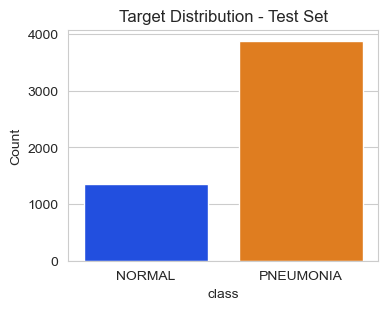

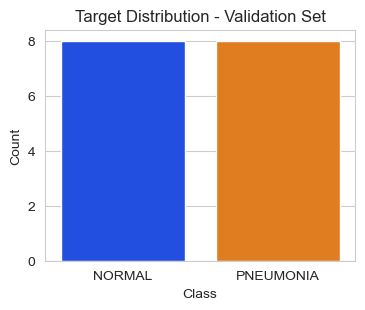

In [5]:
#plotting the target distribution on the data set

sns.set_palette("bright")
sns.set_style("whitegrid")

#ploting the target distribution for the trainset
plt.figure(figsize=(4,3))
sns.countplot(data=df_train, x='class')
plt.title('Target Distribution - Test Set')
plt.xlabel('class')
plt.ylabel('Count')
plt.show()

#ploting the target distribution for the validationset
plt.figure(figsize=(4,3))
sns.countplot(data=df_val, x='class')
plt.title('Target Distribution - Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [6]:
"""
Parameter Tuning: splitting the training dataframe into validation and trainding dataframe with test_size=0.2
and train_size default
"""
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['class'])

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values

# Create data generators
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)

ds_test = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1
)

#reshaped the dataset whcih can fit into the model input shape

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Conv2D(128, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Conv2D(256, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    return model

In [9]:
model = create_model()

In [10]:
from tensorflow.keras.optimizers.legacy import Adam

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 109, 109, 64)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      2

In [12]:
#defining the earlystopping and the reducing learning rate

from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-7,restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss',factor = 0.2,patience = 2,min_delt = 1e-7,cooldown = 0,verbose = 1)

In [ ]:
# Train the model with early stopping
history = model.fit(ds_train,
                    batch_size = 32,
                    epochs = 50,
                    validation_data=ds_val,
                    callbacks=[early_stopping, plateau],
                    steps_per_epoch=(len(train_df)/32),
                    validation_steps=(len(val_df)/32));

Epoch 1/50


2023-07-18 10:24:48.066422: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


131/130 [==============================] - ETA: 0s - loss: 0.4057 - binary_accuracy: 0.8234

2023-07-18 10:28:17.341593: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


130/130 [==============================] - 223s 2s/step - loss: 0.4057 - binary_accuracy: 0.8234 - val_loss: 0.5880 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/50
 29/130 [=====>........................] - ETA: 2:59 - loss: 0.2452 - binary_accuracy: 0.8933